In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import pickle

In [2]:
import sys
sys.path.append("..")

import Essentials


In [3]:
data_archive = np.load('..\Data_Average.npz', allow_pickle=True)

In [4]:
def prepare_Y(y):
    timestamp = y[:, 1]   
    y = y[:, 0].reshape(len(y), 1)
    y = y.astype(np.float64)

    return y, timestamp

In [5]:
X_test_1 = data_archive['X_test_1']
X_train_1 = data_archive['X_train_1']

X_test_2 = data_archive['X_test_2']
X_train_2 = data_archive['X_train_2']

X_test_3 = data_archive['X_test_3']
X_train_3 = data_archive['X_train_3']

Y_test_1, timestamp_test_1 = prepare_Y(data_archive['Y_test_1'])
Y_train_1, timestamp_train_1 = prepare_Y(data_archive['Y_train_1'])

Y_test_2, timestamp_test_2 = prepare_Y(data_archive['Y_test_2'])
Y_train_2, timestamp_train_2 = prepare_Y(data_archive['Y_train_2'])

Y_test_3, timestamp_test_3 = prepare_Y(data_archive['Y_test_3'])
Y_train_3, timestamp_train_3 = prepare_Y(data_archive['Y_train_3'])

In [6]:
df_X1 = pd.read_csv(r'..\raw_X1.csv', index_col=0)
df_X2 = pd.read_csv(r'..\raw_X2.csv', index_col=0)
df_X3 = pd.read_csv(r'..\raw_X3.csv', index_col=0)

In [7]:
labels_1 = list(df_X1.columns)[:-1]
labels_2 = list(df_X2.columns)[:-1]
labels_3 = list(df_X3.columns)[:-1]

In [8]:
class RegressionModel(torch.nn.Module):
    def __init__(self, metric, lr, layers=[]):
        super().__init__()
        self.layers = torch.nn.ModuleList(layers)
        self.metric = metric
        self.lr = lr
        
    def add_layer(self, layer):
        self.layers.append(layer)

    def forward(self, x_dict):
        res = torch.zeros(list(x_dict.values())[0].shape)
        for layer in self.layers:
            res = res + layer(x_dict)
        return res

    def disable_training(self):
        self.layers[0].disable_training(1)
        for layer in self.layers[1:]:
            layer.disable_training(self.lr)

    def get_metric(self, x_dict, y_true):
        y_pred = self.forward(x_dict)
        return self.metric(y_true, y_pred.unsqueeze(-1).detach())

    def get_layers(self):
        return list(self.layers)

    def __str__(self):
        string = ''
        for layer in self.layers:
            string = string + ' + ' + str(layer.lr_coeff) + '*' + layer.__str__()
        return 'Y = ' + string[3:]


In [9]:
class RegressionLayer(torch.nn.Module):
    def __init__(self, torch_layers: list, input_layer, data_from_dict = False):
        super().__init__()
        self.torch_layers = torch.nn.Sequential(*torch_layers)
        self.input_layer = input_layer
        self.data_from_dict = data_from_dict
        self.lr_coeff = 1

    def forward(self, x_dict):
        if self.data_from_dict:
            x_data = x_dict[self]                        
        else:
            x_data = self.input_layer(x_dict)
        if isinstance(self.torch_layers[0], multi_layer):
            return self.torch_layers([x_data, x_dict])
        return self.lr_coeff * self.torch_layers(x_data)

    def __str__(self):
        input_string = self.input_layer.__str__()
        for torch_layer in self.torch_layers:
            torch_layer.set_input(input_string)
            res_string = torch_layer.__str__()
            input_string = res_string
        
        return res_string

    def disable_training(self, lr):
        self.lr_coeff = lr
        for torch_layer in self.torch_layers:
            for param in torch_layer.parameters():
                param.requires_grad = False


In [10]:
class TorchLayer(torch.nn.Module):
    
    size = 0
    ndigs = 2

    def __init__(self):
        super().__init__()
        self.weights = torch.nn.Parameter(torch.empty(self.size))
        torch.nn.init.normal_(self.weights) 
        self.input_layer = None

    def forward(self, x_data):
        pass

    def set_input(self, input_layer):
        self.input_layer = input_layer
    

In [11]:
def round2(weight, ndigits):
    return round(weight.detach().item(), ndigits)

In [12]:
class linear_layer(TorchLayer):
       
    size = 1

    def forward(self, x):
        return self.weights[0]*x

    def __str__(self):
        return f"({round2(self.weights[0], self.ndigs)}) * ({self.input_layer})"  


class exp_layer(TorchLayer):

    size = 2

    def forward(self, x):
        return self.weights[1] * (torch.exp(self.weights[0]*x) - 1)

    def __str__(self):
        return f"({round2(self.weights[1], self.ndigs)}) * (exp({round2(self.weights[0], self.ndigs)} * ({self.input_layer})) - 1)"


class log_layer(TorchLayer):
        
    size = 3

    def forward(self, x):
        return self.weights[2] * torch.log(torch.abs(self.weights[1]*x + self.weights[0]) + 1)

    def __str__(self):
        return f"({round2(self.weights[2], self.ndigs)}) * ln(1 + abs({round2(self.weights[0], self.ndigs)} + ({round2(self.weights[1], self.ndigs)}) * ({self.input_layer})))"    


class start_layer(TorchLayer):
    
    size = 0

    def forward(self, x):
        return x

    def __str__(self):
        return f"{self.input_layer}"  


class const_layer(TorchLayer):
    
    size = 1

    def forward(self, x):
        return self.weights[0] * torch.ones(x.shape)

    def __str__(self):
        return f"({round2(self.weights[0], self.ndigs)})"  


class ReLU_layer(TorchLayer):
        
    size = 3

    def __init__(self):
        super().__init__()
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        tmp = self.weights[1] + x*self.weights[0]
        return self.weights[2] * self.relu(tmp)

    def __str__(self):
        return f"({round2(self.weights[2], self.ndigs)}) * max(0, ({round2(self.weights[0], self.ndigs)}) * ({self.input_layer}) + ({round2(self.weights[1], self.ndigs)})"    


class Tanh_layer(TorchLayer):
        
    size = 3

    def __init__(self):
        super().__init__()
        self.tanh = torch.nn.Tanh()

    def forward(self, x):
        tmp = self.weights[1] + x*self.weights[0]
        return self.weights[2] * self.tanh(tmp)

    def __str__(self):
        return f"({round2(self.weights[2], self.ndigs)}) * tanh(({round2(self.weights[0], self.ndigs)}) * ({self.input_layer}) + ({round2(self.weights[1], self.ndigs)}))"  


class multi_layer(TorchLayer):
        
    size = 1

    def __init__(self, second_layer):
        super().__init__()
        self.second_x = second_layer

    def forward(self, x):
        return self.weights[0] * x[0] * self.second_x(x[1])

    def __str__(self):
        return f"({round2(self.weights[0], self.ndigs)}) * ({self.input_layer}) * ({self.second_x.__str__()})"  


class abs_layer(TorchLayer):
        
    size = 1

    def forward(self, x):
        return self.weights[0] * torch.abs(x)

    def __str__(self):
        return f"({round2(self.weights[0], self.ndigs)}) * abs({self.input_layer})"  


# class pow_layer(TorchLayer):
        
#     size = 2

#     def forward(self, x):
#         return self.weights[2] * torch.pow(torch.abs(x)+0.001, self.weights[0])

#     def __str__(self):
#         return f"({round2(self.weights[1], self.ndigs)}) * (abs({self.input_layer} + 0.001) ** ({round2(self.weights[0], self.ndigs)}))" 

In [27]:
class NonlinearSoftSensor(Essentials.SoftSensor):
    def __init__(self, name, x_train, y_train, x_test, y_test, labels, lr):
        super().__init__(name)
        self.lr = lr
        self.x_scaler = StandardScaler() 
        self.y_scaler = StandardScaler()
        self.fit_scaler(x_train, y_train)
        self.labels = labels

        self.r2_score = Essentials.R2Metric()

        self.labels_x = [RegressionLayer([start_layer()], label, data_from_dict=True) for label in self.labels]
        self.c_label = RegressionLayer([const_layer()], 'const', data_from_dict=True)
        self.labels_x.append(self.c_label)

        self.x_train_model = self.preprocessing(x_train)
        self.y_train_model = self.preprocessing(y_train)
        
        self.x_test_model = self.preprocessing(x_test)
        self.y_test_model = self.preprocessing(y_test)
        
        model = RegressionModel(self.r2_score, self.lr)
        model.add_layer(RegressionLayer([const_layer()], self.c_label))
        
        self.criterion = torch.nn.MSELoss()
        self.train_model(model, self.x_train_model, self.y_train_model)
        model.disable_training()
        self.set_model(model)
        

    def preprocessing(self, x):
        try:
            X_norm = self.x_scaler.transform(x)
            vectors_x = [torch.tensor(col, dtype=torch.float32) for col in X_norm.T]
            vectors_x.append(torch.ones(vectors_x[0].shape))
            return {key: value for key, value in zip(self.labels_x, vectors_x)}
        except:
            try:
                Y_norm = self.y_scaler.transform(x)
                return torch.tensor(Y_norm, dtype=torch.float32)
            except BaseException as err:
                print("Ошибка скейлера")
                raise err
        
            
    def fit_scaler(self, x_train, y_train):
        self.x_scaler.fit(x_train)
        self.y_scaler.fit(y_train)

    def train_model(self, model, X, Y, lr=0.005, epoch_num=1000, verbose=False):    
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
        for i in range(epoch_num):
            optimizer.zero_grad()
            Y_pred = model(X)
            loss = self.criterion(Y_pred, Y.squeeze())
            loss.backward()
            optimizer.step()
            if verbose:
                print(loss.item()) 

    
    def postprocessing(self, x):
        try:
            x_post = x.detach().numpy()
            return self.x_scaler.inverse_transform(x_post)
        except:
            try:
                x_post = x.detach().numpy().reshape(-1, 1)
                return self.y_scaler.inverse_transform(x_post)
            except BaseException as err:
                print("Ошибка скейлера")
                raise err

    def evaluate_model(self, x):
        model = self.get_model()
        return model(x)


    def train(self, possible_layers, comb_layers, max_layers, min_diff=1.01, verbose=False, verbose2=True):
        
        start_layers = self.labels_x[:-1]
        
        x1 = self.x_train_model
        y1 = self.y_train_model
        
        x2 = self.x_test_model
        y2 = self.y_test_model        
        
        Model = self.get_model()    
        model_layers = Model.get_layers()       
                
        # iterate over max_layers
        for i in range(max_layers):
            best_layers = None
            best_step_score = Model.get_metric(x1, y1)
            Model.disable_training()
        
            for prev_layer in (start_layers + model_layers):
                if isinstance(prev_layer.torch_layers[0], const_layer):
                    continue
               
                for layer in (comb_layers + possible_layers):
        
                    if layer in comb_layers:
                        for second_layer in (start_layers + model_layers):
                            if isinstance(second_layer.torch_layers[0], const_layer):
                                continue
                            step_layers = Model.get_layers()
                            step_layers.append(RegressionLayer([layer(second_layer)], prev_layer))
                            if verbose2:
                                print(f"Testing layer {layer.__name__} for {prev_layer.__str__()} and {second_layer.__str__()}")
                                
                            step_model = RegressionModel(self.r2_score, self.lr, step_layers)
                            self.train_model(step_model, x1, y1, epoch_num=1000, verbose=verbose)
                            step_score = step_model.get_metric(x1, y1)
                            if verbose2:
                                print(f'Got metric value {step_score}')
                
                            if step_score > best_step_score:
                                best_step_score = step_score
                                best_layers = step_layers
                                
                    else:
                        step_layers = Model.get_layers()
                        step_layers.append(RegressionLayer([layer()], prev_layer))
                        if verbose2:
                            print(f"Testing layer {layer.__name__} for {prev_layer.__str__()}")          
                           
                        step_model = RegressionModel(self.r2_score, self.lr, step_layers)
                        self.train_model(step_model, x1, y1, epoch_num=1000, verbose=verbose)
                        step_score = step_model.get_metric(x1, y1)
                        if verbose2:
                            print(f'Got metric value {step_score}')
            
                        if step_score > best_step_score:
                            best_step_score = step_score
                            best_layers = step_model.get_layers()
                    
        
            print(f"Done layer {i+1} \n")
        
            if best_layers is None:
                print('No better layers')
                break
        
            if best_step_score < min_diff*Model.get_metric(x1, y1):
                print("Weak increase")
                break
        
            Model = RegressionModel(self.r2_score, self.lr, best_layers)
            model_layers = Model.get_layers()
            print("New model: \n")
            print(Model, '\n')
            print(f'New best score {Model.get_metric(x1, y1)} \n')
            print(f'New score on Test {Model.get_metric(x2, y2)} \n')
            print('-------------------------------------------------------------------------------------------------------------------------------')
            
                

        self.set_model(Model)


    def __str__(self):
        return f'Нелинейная модель для {self.get_name()}: \n \n {self.get_model().__str__()}'

    def save(self, name):
        pickle.dump(self, file = open(f'{name}.pickle', "wb"))

In [28]:
possible_layers = [linear_layer, exp_layer, log_layer, ReLU_layer, Tanh_layer, abs_layer]
# comb_layers = [multi_layer]
# possible_layers = [linear_layer]
comb_layers = []

In [30]:
Nonlinear_model_2 = NonlinearSoftSensor('Конец кипения легкого бензина', X_train_2, Y_train_2, X_test_2, Y_test_2, labels_2, lr=0.33)
Nonlinear_model_2.train(possible_layers=possible_layers, comb_layers=comb_layers, max_layers=5, min_diff=1.01, verbose=False, verbose2=False)

Done layer 1 

New model: 

Y = 1*(-0.04) + 1*(1.13) * tanh((0.88) * (Температура 9-ой тарелки С-1101) + (-0.05)) 

New best score 0.49302923883825966 

New score on Test 0.4604263754954021 

-------------------------------------------------------------------------------------------------------------------------------
Done layer 2 

New model: 

Y = 1*(-0.04) + 0.33*(1.13) * tanh((0.88) * (Температура 9-ой тарелки С-1101) + (-0.05)) + 1*(1.23) * tanh((1.78) * ((1.13) * tanh((0.88) * (Температура 9-ой тарелки С-1101) + (-0.05))) + (0.05)) 

New best score 0.4955141948702322 

New score on Test 0.4509617239058037 

-------------------------------------------------------------------------------------------------------------------------------
Done layer 3 

New model: 

Y = 1*(-0.04) + 0.33*(1.13) * tanh((0.88) * (Температура 9-ой тарелки С-1101) + (-0.05)) + 0.33*(1.23) * tanh((1.78) * ((1.13) * tanh((0.88) * (Температура 9-ой тарелки С-1101) + (-0.05))) + (0.05)) + 1*(0.39) * tanh((2.63)

In [31]:
print(Nonlinear_model_2)

Нелинейная модель для Конец кипения легкого бензина: 
 
 Y = 1*(-0.04) + 0.33*(1.13) * tanh((0.88) * (Температура 9-ой тарелки С-1101) + (-0.05)) + 0.33*(1.23) * tanh((1.78) * ((1.13) * tanh((0.88) * (Температура 9-ой тарелки С-1101) + (-0.05))) + (0.05)) + 0.33*(0.39) * tanh((2.63) * (Расход ЛБ от С-1101) + (-0.96)) + 0.33*(0.73) * max(0, (0.91) * (Температура 9-ой тарелки С-1101) + (-0.48) + 1*(0.82) * tanh((2.91) * ((0.73) * max(0, (0.91) * (Температура 9-ой тарелки С-1101) + (-0.48)) + (-0.1))


In [32]:
metric = Essentials.R2Metric()

In [34]:
Nonlinear_visual_2_train = Essentials.Visualizer(X_train_2, Y_train_2, timestamp_train_2, [metric], 'Nonlinear SoftSensor R2 metric on Train')

                               Coefficient of determination
Конец кипения легкого бензина                      0.541623


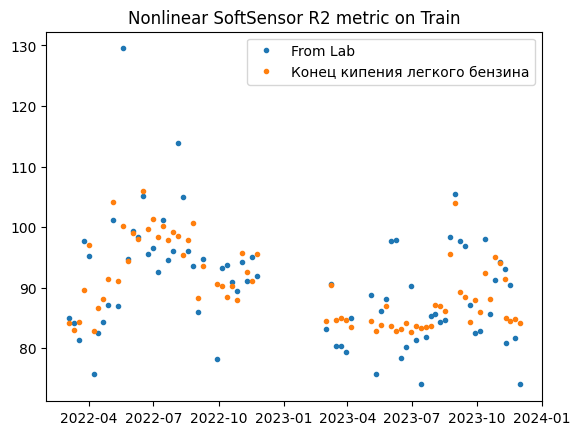

In [35]:
Nonlinear_visual_2_train.visualize([Nonlinear_model_2])

In [36]:
Nonlinear_visual_2_test = Essentials.Visualizer(X_test_2, Y_test_2, timestamp_test_2, [metric], 'Nonlinear SoftSensor R2 metric on Test')

                               Coefficient of determination
Конец кипения легкого бензина                      0.468892


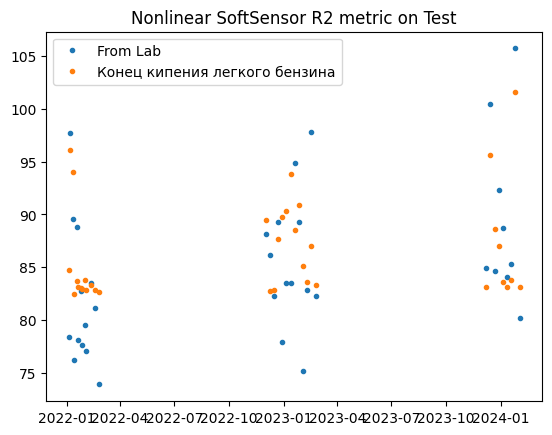

In [37]:
Nonlinear_visual_2_test.visualize([Nonlinear_model_2])

In [38]:
Nonlinear_model_2.save('Nonlinear_model_2')

Чтобы загрузить команда - 

pickle.load(open("{name}.pickle", "rb"))